In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import networkx as nx
from scipy.spatial.distance import cosine
from scipy.stats import ks_2samp

______________________________

In [2]:
network = 'tarbase'
target_homology = 'mix'

lca_source = 'mirgenedb'  # Options: 'mirgenedb' or 'ensembl'

remove_SSD_pre_2R = False
keep_SSD_pre_2R = False

if remove_SSD_pre_2R and keep_SSD_pre_2R:
	raise ValueError("Cannot both remove and keep pre-2R SSD pairs. Choose one option or remove both.")

s = target_homology

if remove_SSD_pre_2R:
	s += 'post_2R'
elif keep_SSD_pre_2R:
	s += 'pre_2R'
else:
	s += ''

remove_large_fam = True
if remove_large_fam:
	max_n_nodes = 4
	s += f'cc_largerthan{str(max_n_nodes)}_removed'

remove_undistinguished_pairs = True
if remove_undistinguished_pairs:
	s += '_undistinguished_pairs_removed'

print("ID string:", s)

ID string: mixcc_largerthan4_removed_undistinguished_pairs_removed


In [3]:
if target_homology == 'wgd':
	file_path_1 = f'./output/{network}_om.z_1000.tsv'
	file_path_2 = f'./output/{network}_pm_mixed.z_1000.tsv'
elif target_homology == 'ssd':
	file_path_1 = f'./output/{network}_om_mixed.z_1000.tsv'
	file_path_2 = f'./output/{network}_pm.z_1000.tsv'
elif target_homology == 'mix':
	file_path_1 = f'./output/{network}_om.z_1000.tsv'
	file_path_2 = f'./output/{network}_pm.z_1000.tsv'
else:
	raise ValueError("target_homology must be either 'wgd', 'ssd' or 'mix'")

df_1 = pd.read_csv(file_path_1, sep='\t', header=0)
df_2 = pd.read_csv(file_path_2, sep='\t', header=0)

In [4]:
ensembl_mirna_pair_lca_file_path = '../../3_retrieve_Hsa_paralogs/all_hsa_ensembl_paralogmirna_clean.tsv'
df_mirna_pair_lca = pd.read_csv(ensembl_mirna_pair_lca_file_path, sep='\t', header=None)
ensembl_pair_lca_dict = {}
for _, row in df_mirna_pair_lca.iterrows():
	ensembl_pair_lca_dict[(row[1], row[3])] = row[4]
	ensembl_pair_lca_dict[(row[3], row[1])] = row[4]

In [5]:
mirna_origin_file_path = '../../MirGeneDB_miRNA_origin/hsa_mirgenedb3.0_to_everything.mirna_origin.tsv'
df_mirgenedb_mirna_origin = pd.read_csv(mirna_origin_file_path, sep='\t', header=None)
# keep only columns 8,14,15 and remove duplicates
df_mirgenedb_mirna_origin = df_mirgenedb_mirna_origin[[8, 14, 15]]
df_mirgenedb_mirna_origin = df_mirgenedb_mirna_origin.drop_duplicates()
cols = ["miRNA", "locus_node_of_origin", "family_node_of_origin"]
df_mirgenedb_mirna_origin.columns = cols
df_mirgenedb_mirna_origin

mirna_lno_dict = {}
for index, row in df_mirgenedb_mirna_origin.iterrows():
	mirna = row['miRNA']
	lno = row['family_node_of_origin']
	if mirna not in mirna_lno_dict:
		mirna_lno_dict[mirna] = []
	mirna_lno_dict[mirna].append(lno)

In [6]:
ordered_lca = {
	'Eumetazoa': 0,
	'Bilateria': 1,
	'Nephrozoa': 2,
	'Chordata': 3,
	'Olfactores': 4,
	'Vertebrata': 5,
	'Gnathostomata': 6,
	'Osteichthyes': 7,
	'Euteleostomi': 8,
	'Sarcopterygii': 9,
	'Tetrapoda': 10,
	'Amniota': 11,
	'Mammalia': 12,
	'Theria': 13,
	'Eutheria': 14,
	'Boroeutheria': 15,
	'Euarchontoglires': 16,
	'Primates': 17,
	'Simiiformes': 18,
	'Catarrhini': 19,
	'Hominidae': 20,
	'Homo_sapiens': 21
}

reverted_ordered_lca_dict = {v: k for k, v in ordered_lca.items()}

In [7]:
reverted_ordered_lca_dict

{0: 'Eumetazoa',
 1: 'Bilateria',
 2: 'Nephrozoa',
 3: 'Chordata',
 4: 'Olfactores',
 5: 'Vertebrata',
 6: 'Gnathostomata',
 7: 'Osteichthyes',
 8: 'Euteleostomi',
 9: 'Sarcopterygii',
 10: 'Tetrapoda',
 11: 'Amniota',
 12: 'Mammalia',
 13: 'Theria',
 14: 'Eutheria',
 15: 'Boroeutheria',
 16: 'Euarchontoglires',
 17: 'Primates',
 18: 'Simiiformes',
 19: 'Catarrhini',
 20: 'Hominidae',
 21: 'Homo_sapiens'}

In [8]:
df_wgd = df_1
df_ssd = df_2

In [9]:
if remove_undistinguished_pairs:
	df_wgd = df_wgd[~((df_wgd['n_common_targets'] == df_wgd['n_tar_1']) & (df_wgd['n_common_targets'] == df_wgd['n_tar_2']))]
	df_ssd = df_ssd[~((df_ssd['n_common_targets'] == df_ssd['n_tar_1']) & (df_ssd['n_common_targets'] == df_ssd['n_tar_2']))]

In [10]:
def add_ensembl_lca(df, dict):
    df_cp = df.copy()
    df_cp['lca'] = df_cp.apply(lambda row: dict.get((row['miRNA_1'], row['miRNA_2'])), axis=1)
    return df_cp

def add_mirgenedb_lca(df, single_miRNA_dict, reverted_lca_dict):
	df_cp = df.copy()
	def compute_max_lca(miRNA):
		# If the miRNA value itself is NaN/null, skip immediately
		if pd.isna(miRNA):
			return -1
		# Look up its list of lno’s; if that’s not a list/tuple, treat as empty
		lno_list = single_miRNA_dict.get(miRNA, [])
		if not isinstance(lno_list, (list, tuple)):
			return -1
		# Map to ordered_lca values and take the max (or -1 if empty)
		return max((ordered_lca.get(lno, -1) for lno in lno_list), default=-1)

	df_cp['lca_1']    = df_cp['miRNA_1'].apply(compute_max_lca)
	df_cp['lca_2']    = df_cp['miRNA_2'].apply(compute_max_lca)
	df_cp['lca_code']= df_cp[['lca_1','lca_2']].max(axis=1)
	df_cp = df_cp.drop(columns=['lca_1','lca_2'])

    # **just use the dict you passed in**
	df_cp['lca'] = df_cp['lca_code'].apply(
		lambda code: reverted_lca_dict.get(code, 'Unknown')
	)
	return df_cp

if lca_source == "ensembl":
    print("Using Ensembl for LCA")
    df_wgd_lca = add_ensembl_lca(df_wgd, ensembl_pair_lca_dict)
    df_ssd_lca = add_ensembl_lca(df_ssd, ensembl_pair_lca_dict)
elif lca_source == "mirgenedb":
    print("Using MirGeneDB for LCA")
    df_wgd_lca = add_mirgenedb_lca(df_wgd, mirna_lno_dict, reverted_ordered_lca_dict)
    df_ssd_lca = add_mirgenedb_lca(df_ssd, mirna_lno_dict, reverted_ordered_lca_dict)
else:
    raise ValueError(f"{lca_source} is an invalid LCA source. Using MirGeneDB.")


Using MirGeneDB for LCA


In [11]:
df_wgd_lca[df_wgd_lca['lca']=='None']

,miRNA_1,miRNA_2,n_tar_1,n_tar_2,n_common_targets,mu,sigma,n_relevant_bifan,n_maj_true,Z-score,pValue (nm size=1000),lca_code,lca


In [12]:
print("Number of WGD pairs: ", len(df_wgd_lca))
print("Number of SSD pairs: ", len(df_ssd_lca))

Number of WGD pairs:  101
Number of SSD pairs:  1347


In [13]:
pre_2R_clades = ['Bilateria', 'Chordata', 'Eumetazoa', 'Vertebrata', 'Nephrozoa', 'Olphactores']

if remove_SSD_pre_2R:
	df_ssd_lca = df_ssd_lca[~df_ssd_lca['lca'].isin(pre_2R_clades)]
if keep_SSD_pre_2R:
	df_ssd_lca = df_ssd_lca[df_ssd_lca['lca'].isin(pre_2R_clades)]

print("Number of WGD pairs: ", len(df_wgd_lca))
print("Number of SSD pairs: ", len(df_ssd_lca))

Number of WGD pairs:  101
Number of SSD pairs:  1347


In [14]:
def remove_large_cc(df, max_size):
    df['Z-score'] = pd.to_numeric(df['Z-score'], errors='coerce')
    G = nx.Graph()
    for _, row in df.iterrows():
        G.add_edge(row['miRNA_1'], row['miRNA_2'])

    # Identify connected components
    large_components = [comp for comp in nx.connected_components(G) if len(comp) > max_size]

    if not large_components:
        return df

    # Process each large component separately
    indices_to_keep = set()

    for comp in large_components:
        comp_df = df[(df['miRNA_1'].isin(comp)) & (df['miRNA_2'].isin(comp))]
        top_pairs = comp_df.nlargest(max_size, 'Z-score')
        indices_to_keep.update(top_pairs.index)

    # Identify edges to retain from small components
    small_components = [comp for comp in nx.connected_components(G) if len(comp) <= max_size]
    for comp in small_components:
        comp_df = df[(df['miRNA_1'].isin(comp)) & (df['miRNA_2'].isin(comp))]
        indices_to_keep.update(comp_df.index)

    return df.loc[sorted(indices_to_keep)].reset_index(drop=True)

In [15]:
def remove_mirna_pairs(df1, df2):
	"""
	Removes from df1 all rows whose (miRNA_1, miRNA_2) pairs (regardless of order)
	are present in df2.
	"""
	# Create a set of tuples for the miRNA pairs in df2
	mirna_pairs = set()
	for _, row in df2.iterrows():
		mirna1 = row['miRNA_1']
		mirna2 = row['miRNA_2']
		if mirna1 != mirna2:
			mirna_pairs.add(tuple(sorted([mirna1, mirna2])))

	# Filter df1 to remove rows with miRNA pairs present in df2
	filtered_df = df1[~df1.apply(lambda row: tuple(sorted([row['miRNA_1'], row['miRNA_2']])) in mirna_pairs, axis=1)]
	
	return filtered_df


df_ssd_lca = remove_mirna_pairs(df_ssd_lca, df_wgd_lca)

print("Number of WGD pairs after removing miRNA pairs from SSD: ", len(df_wgd_lca))
print("Number of SSD pairs after removing miRNA pairs from SSD: ", len(df_ssd_lca))

Number of WGD pairs after removing miRNA pairs from SSD:  101
Number of SSD pairs after removing miRNA pairs from SSD:  1247


In [16]:
def remove_sigma_err(df):
    # Step 1: Set Z-score to 0 if Z-score == 'sigma_err' and n_relevant_bifan == 0
    mask_fix = (df['Z-score'] == 'sigma_err') & (df['n_relevant_bifan'] == 0)
    df.loc[mask_fix, 'Z-score'] = 0

    # Step 2: Remove rows where Z-score == 'sigma_err' and n_relevant_bifan != 0
    mask_remove = (df['Z-score'] == 'sigma_err') & (df['n_relevant_bifan'] != 0)
    df = df[~mask_remove]

    return df

max_n_nodes = 2
if remove_large_fam:
	df_ssd_lca_parsed = remove_large_cc(remove_sigma_err(df_ssd_lca), max_n_nodes)
	df_wgd_lca_parsed = remove_large_cc(remove_sigma_err(df_wgd_lca), max_n_nodes)
else:
	# df_ssd_lca_parsed = remove_sigma_err(df_ssd_lca), max_n_nodes
	# df_wgd_lca_parsed = remove_sigma_err(df_wgd_lca), max_n_nodes
	df_ssd_lca_parsed = remove_large_cc(remove_sigma_err(df_ssd_lca), max_n_nodes)
	df_wgd_lca_parsed =  remove_large_cc(remove_sigma_err(df_wgd_lca), max_n_nodes)

/tmp/ipykernel_2503/181018177.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Z-score'] = pd.to_numeric(df['Z-score'], errors='coerce')


In [17]:
df_wgd_lca_zscores = df_wgd_lca_parsed['Z-score'].astype(float)
df_ssd_lca_zscores = df_ssd_lca_parsed['Z-score'].astype(float)

df_wgd_lca_nbifan = df_wgd_lca_parsed['n_relevant_bifan'].astype(int)
df_ssd_lca_nbifan = df_ssd_lca_parsed['n_relevant_bifan'].astype(int)

In [18]:
n_wgd = len(df_wgd_lca_zscores)
n_ssd = len(df_ssd_lca_zscores)

print("n_wgd in the boxplot: ", n_wgd)
print("n_ssd in the boxplot: ", n_ssd)

n_wgd in the boxplot:  74
n_ssd in the boxplot:  54


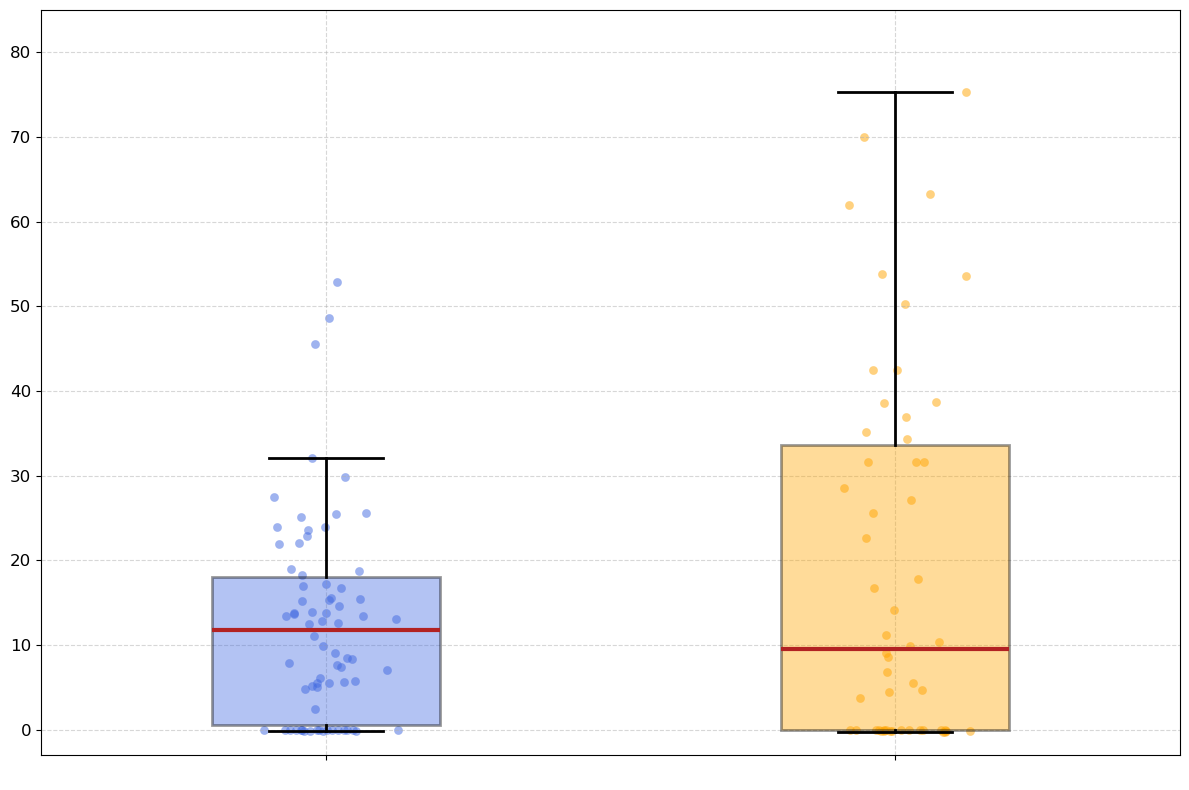

Number of WGD pairs: 74
Number of SSD pairs: 54


In [19]:
data = [df_wgd_lca_zscores, df_ssd_lca_zscores]
positions = [0, 1]
colors = ['royalblue', 'orange']

plt.figure(figsize=(12, 8))

box = plt.boxplot(data, 
                  positions=positions, 
                  widths=0.4,
                  patch_artist=True, 
                  showfliers=False)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')
    patch.set_linewidth(2)
    patch.set_alpha(0.4)
    
for element in ['whiskers', 'caps']:
    for line in box[element]:
        line.set_linewidth(2)
        line.set_color('black')
        
for element in ['medians']:
    for line in box[element]:
        line.set_linewidth(3)
        line.set_color('firebrick')

for i, (scores, color) in enumerate(zip(data, colors)):
    jittered_x = np.random.normal(loc=positions[i], scale=0.05, size=len(scores))
    plt.scatter(jittered_x, scores, alpha=0.5, color=color, linewidth=0.2, label=['', ''][i])

plt.xticks(positions, [' ', ' '], fontsize=100)
plt.ylim(-3, 85)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.savefig(f'../../local/pictures/{network}_bifan_zscores_boxplot_{s}.jpg', bbox_inches='tight')
plt.show()

print(f"Number of WGD pairs: {len(df_wgd_lca_parsed)}")
print(f"Number of SSD pairs: {len(df_ssd_lca_parsed)}")

In [20]:
thr=3
def count_ssd_pairs_above_threshold(df, threshold):
	return len(df[df['Z-score'].astype(float) > threshold])
n_ssd_above_thr = count_ssd_pairs_above_threshold(df_ssd_lca_parsed, thr)
print(f"Number of SSD pairs with Z-score > {str(thr)}: {n_ssd_above_thr}")
n_wgd_above_thr = count_ssd_pairs_above_threshold(df_wgd_lca_parsed, thr)
print(f"Number of WGD pairs with Z-score > {str(thr)}: {n_wgd_above_thr}")

Number of SSD pairs with Z-score > 3: 34
Number of WGD pairs with Z-score > 3: 54


In [21]:
#ks_stat, ks_p_value = stats.ks_2samp(df_wgd_lca_zscores, df_ssd_lca_zscores)
ks_stat, ks_p_value = stats.ks_2samp(df_ssd_lca_zscores, df_wgd_lca_zscores)
ks_stat_sign = np.sign(ks_stat)

print(f"KS test results with parameters:\nnetwork={network}\ntarget_homology={target_homology}\nremove_pre_2R={remove_SSD_pre_2R}")
print(75 * "=")
print(f"KS statistic: {ks_stat}, p-value: {ks_p_value}")
print(f"KS statistic sign: {ks_stat_sign}")

KS test results with parameters:
network=tarbase
target_homology=mix
remove_pre_2R=False
KS statistic: 0.26226226226226224, p-value: 0.0214609872343073
KS statistic sign: 1.0


In [22]:
u_stat, u_p_value = stats.mannwhitneyu(df_wgd_lca_zscores, df_ssd_lca_zscores, alternative='two-sided')
print(f"Mann-Whitney U test results:\nU statistic: {u_stat}, p-value: {u_p_value}")
print(75 * "=")

Mann-Whitney U test results:
U statistic: 1931.0, p-value: 0.7478562086572693


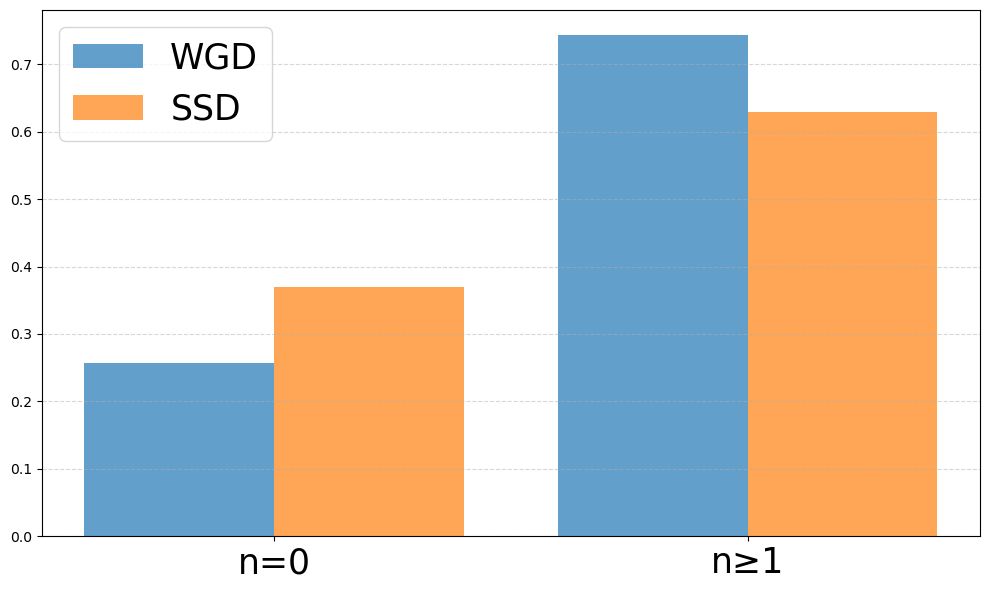

In [23]:
labels = ['n=0', 'n≥1']

def bin_bifans(count, labels=labels):
    if count == 0:
        return labels[0]
    else:
        return labels[1]

# Bin the counts
wgd_binned = pd.Series(df_wgd_lca_nbifan).apply(bin_bifans)
ssd_binned = pd.Series(df_ssd_lca_nbifan).apply(bin_bifans)

# Get relative frequencies for each bin
wgd_freq = wgd_binned.value_counts(normalize=True).reindex(labels, fill_value=0)
ssd_freq = ssd_binned.value_counts(normalize=True).reindex(labels, fill_value=0)

x = np.arange(len(labels))
width = 0.4

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, wgd_freq, width=width, label='WGD', alpha=0.7)
plt.bar(x + width/2, ssd_freq, width=width, label='SSD', alpha=0.7)

plt.xticks(x, labels, fontsize=25)
plt.xlabel('')
plt.title('')
plt.legend(fontsize=25)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(f'../../local/pictures/{network}_bifan_nmotif_barplot_{s}.jpg', bbox_inches='tight')
plt.show()

________________________________________

## Subgenome analysis

In [54]:
subg_file = '../../1.1_retrieve_Hsa_ohnomirnas/gnathostomata_ohnolog_reference_singlecol.gene.tsv'
df_subg = pd.read_csv(subg_file, sep='\t', header=None)
cols = ['miRNA', 'subgenome', 'CLG']
df_subg.columns = cols
df_subg

def label_subgenome(df_dup, df_subg, prefix):
    # Create a dictionary from df_subg (miRNA -> subgenome)
    subg_dict = dict(zip(df_subg['miRNA'], df_subg['subgenome']))

    # Function to translate and label each miRNA
    def translate_miRNA(miRNA):
        miRNA_clean = miRNA.replace(prefix, "")
        return subg_dict.get(miRNA_clean, 'unknown')

    # Apply subgenome labels
    df_dup_cp = df_dup.copy()
    df_dup_cp['subg_1'] = df_dup_cp['miRNA_1'].apply(translate_miRNA)
    df_dup_cp['subg_2'] = df_dup_cp['miRNA_2'].apply(translate_miRNA)

    # Split into numeric and Greek part
    df_dup_cp['miRNA_1_1R'] = df_dup_cp['subg_1'].str.extract(r'(\d)')
    df_dup_cp['miRNA_1_2R'] = df_dup_cp['subg_1'].str.extract(r'(alpha|beta)')

    df_dup_cp['miRNA_2_1R'] = df_dup_cp['subg_2'].str.extract(r'(\d)')
    df_dup_cp['miRNA_2_2R'] = df_dup_cp['subg_2'].str.extract(r'(alpha|beta)')

    return df_dup_cp

df_wgd_lca_parsed_subg = label_subgenome(df_wgd_lca, df_subg, '')

n_1 =  32
n_2 =  33
n_3 =  27
n_4 =  9


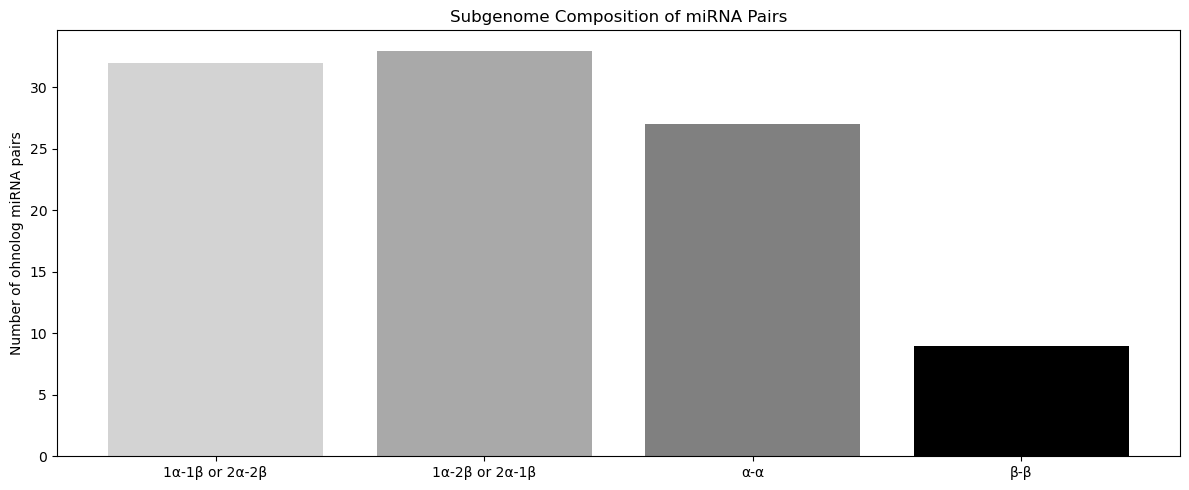

In [55]:
mask_1 = (
    ((df_wgd_lca_parsed_subg['miRNA_1_2R'] == 'alpha') & (df_wgd_lca_parsed_subg['miRNA_2_2R'] == 'beta') & (df_wgd_lca_parsed_subg['miRNA_1_1R'] == df_wgd_lca_parsed_subg['miRNA_2_1R'])) |
    ((df_wgd_lca_parsed_subg['miRNA_1_2R'] == 'beta') & (df_wgd_lca_parsed_subg['miRNA_2_2R'] == 'alpha') & (df_wgd_lca_parsed_subg['miRNA_1_1R'] == df_wgd_lca_parsed_subg['miRNA_2_1R']))
)

mask_2 = (
    ((df_wgd_lca_parsed_subg['miRNA_1_2R'] == 'alpha') & (df_wgd_lca_parsed_subg['miRNA_2_2R'] == 'beta') & (df_wgd_lca_parsed_subg['miRNA_1_1R'] != df_wgd_lca_parsed_subg['miRNA_2_1R'])) |
    ((df_wgd_lca_parsed_subg['miRNA_1_2R'] == 'beta') & (df_wgd_lca_parsed_subg['miRNA_2_2R'] == 'alpha') & (df_wgd_lca_parsed_subg['miRNA_1_1R'] != df_wgd_lca_parsed_subg['miRNA_2_1R']))
)

mask_3 = (
	(df_wgd_lca_parsed_subg['miRNA_1_2R'] == 'alpha') & (df_wgd_lca_parsed_subg['miRNA_2_2R'] == 'alpha') 
)

mask_4 = (
	(df_wgd_lca_parsed_subg['miRNA_1_2R'] == 'beta') & (df_wgd_lca_parsed_subg['miRNA_2_2R'] == 'beta') 
)

# add a column named "dup_subgenome_type" with "A" if mask_1 is True, "B" if mask_2 is True, and "C" if mask_3 is True
df_wgd_lca_parsed_subg['dup_subgenome_type'] = np.select(
	[mask_1, mask_2, mask_3, mask_4],
	['A', 'B', 'C', 'D']
)

n_1 = df_wgd_lca_parsed_subg[mask_1].shape[0]
n_2 = df_wgd_lca_parsed_subg[mask_2].shape[0]
n_3= df_wgd_lca_parsed_subg[mask_3].shape[0]
n_4 = df_wgd_lca_parsed_subg[mask_4].shape[0]

print("n_1 = ", n_1)
print("n_2 = ", n_2)
print("n_3 = ", n_3)
print("n_4 = ", n_4)

# Plot
plt.figure(figsize=(12, 5))
plt.bar(['1α-1β or 2α-2β', '1α-2β or 2α-1β', 'α-α', 'β-β'], [n_1, n_2, n_3, n_4], color=['lightgrey', 'darkgrey', 'grey', 'black'])
plt.ylabel('Number of ohnolog miRNA pairs')
plt.title('Subgenome Composition of miRNA Pairs')
plt.tight_layout()
plt.savefig(f'../../local/pictures/bifan_subgenome_numbers_{s}.jpg', bbox_inches='tight')
plt.show()

In [56]:
# collapse C and D in the same column
df_wgd_lca_parsed_subg['dup_subgenome_type'] = df_wgd_lca_parsed_subg['dup_subgenome_type'].replace({'C': 'C+D', 'D': 'C+D'})

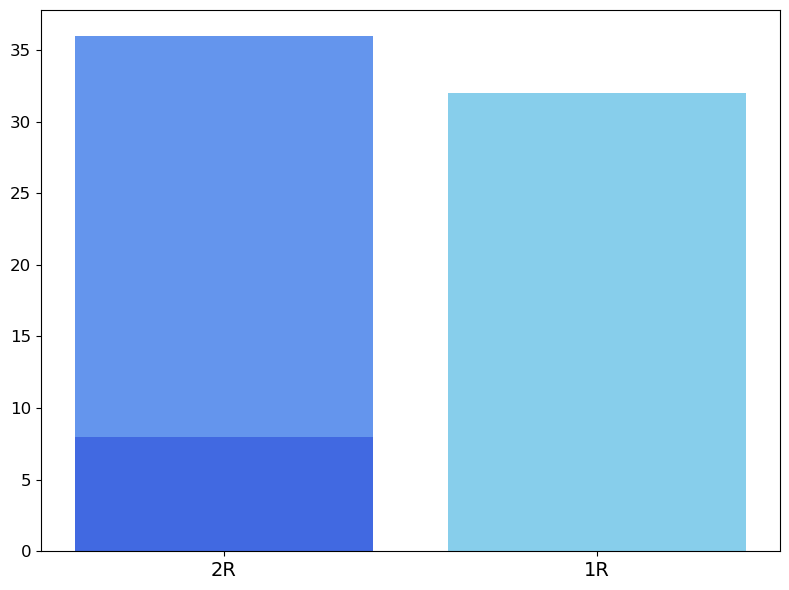

In [57]:
# plot a barplot with the number of pairs for each of the two subgenome types (A and C+D)
def plot_subgenome_distribution(df, title, h, s):
    # Inverted order: C+D (2R) on the left, A (1R) on the right
    counts = ['C+D', 'A']
    labels = ['2R', '1R']
    heights = [df[df['dup_subgenome_type'] == c].shape[0] for c in counts]
    
    plt.figure(figsize=(8, 6))
    
    # Plot first bar (C+D) with two-tone color split at h
    height_cd = heights[0]
    if height_cd > h:
        plt.bar(labels[0], h, color='royalblue')
        plt.bar(labels[0], height_cd - h, bottom=h, color='cornflowerblue')
    else:
        plt.bar(labels[0], height_cd, color='royalblue')

    # Plot second bar (A) as full bar
    plt.bar(labels[1], heights[1], color='skyblue')
    
    plt.xlabel('', fontsize=14)
    plt.ylabel('', fontsize=14)
    plt.title(title, fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.savefig(f'../../local/pictures/ppi_bifan_subgenome_distribution_{s}.jpg', bbox_inches='tight')
    plt.show()

plot_subgenome_distribution(df_wgd_lca_parsed_subg, '', 8, s)

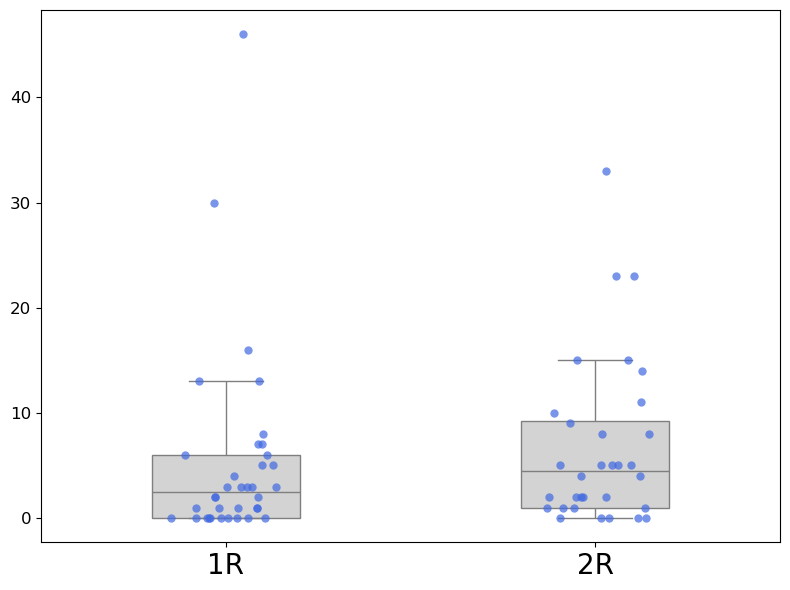

KS test for subgenome types:
KS statistic: 0.2013888888888889, p-value: 0.4321163770767723
Subset sizes:
A: 32
C+D: 36


In [58]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='dup_subgenome_type', y='n_relevant_bifan', data=df_wgd_lca_parsed_subg, 
			order=['C+D', 'A'], showfliers=False, width=0.4, linewidth=1, color='lightgrey')
sns.stripplot(x='dup_subgenome_type', y='n_relevant_bifan', data=df_wgd_lca_parsed_subg, 
			order=['C+D', 'A'], color='royalblue', alpha=0.7, s=6, jitter=0.15)
plt.xlabel('', fontsize=14)
plt.ylabel('', fontsize=14)
v = ['1R', '2R']
plt.xticks(ticks=range(len(v)), labels=v, fontsize=12)
plt.title('', fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(f'../../local/pictures/bifan_subgenome_nbifan_{s}.jpg', bbox_inches='tight')
plt.show()

# print K-S test for subgenome types
ks_stat_subg, ks_p_value_subg = stats.ks_2samp(
	df_wgd_lca_parsed_subg[df_wgd_lca_parsed_subg['dup_subgenome_type'] == 'A']['n_relevant_bifan'].astype(float),
	df_wgd_lca_parsed_subg[df_wgd_lca_parsed_subg['dup_subgenome_type'] == 'C+D']['n_relevant_bifan'].astype(float)
)
print(f"KS test for subgenome types:\nKS statistic: {ks_stat_subg}, p-value: {ks_p_value_subg}")
print("Subset sizes:"
	f"\nA: {df_wgd_lca_parsed_subg[df_wgd_lca_parsed_subg['dup_subgenome_type'] == 'A'].shape[0]}"
	f"\nC+D: {df_wgd_lca_parsed_subg[df_wgd_lca_parsed_subg['dup_subgenome_type'] == 'C+D'].shape[0]}")

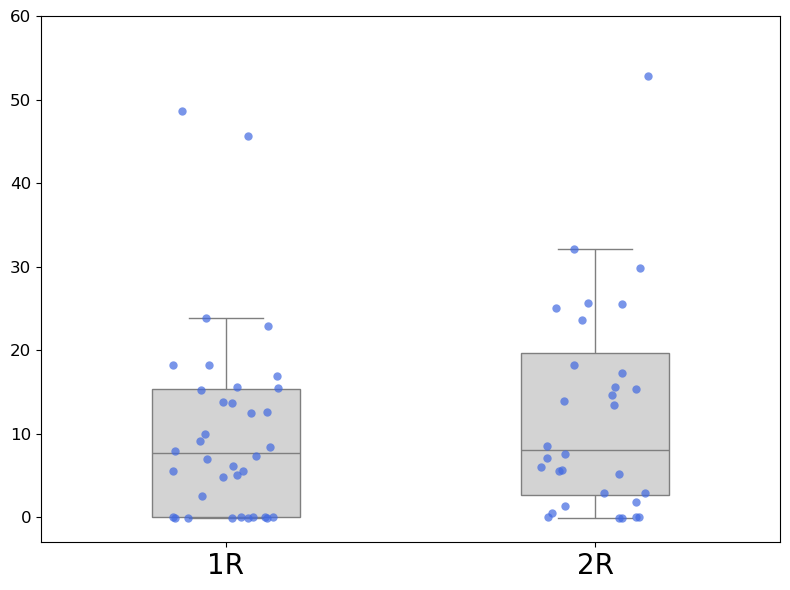

KS test for subgenome types:
KS statistic: 0.16666666666666666, p-value: 0.661965756533011
Number of pairs in A: 32, in C+D: 36


In [74]:
plt.figure(figsize=(8, 6))

# define a local version of the df to handle z-scores properly
df_wgd_lca_parsed_subg_z = df_wgd_lca_parsed_subg.copy()
df_wgd_lca_parsed_subg_z = df_wgd_lca_parsed_subg_z[df_wgd_lca_parsed_subg_z['Z-score'] != 'sigma_err']
df_wgd_lca_parsed_subg_z['Z-score'] = pd.to_numeric(df_wgd_lca_parsed_subg_z['Z-score'], errors='coerce')
df_wgd_lca_parsed_subg_z = df_wgd_lca_parsed_subg_z.dropna(subset=['Z-score'])

sns.boxplot(x='dup_subgenome_type', y='Z-score', data=df_wgd_lca_parsed_subg_z, 
			order=['C+D', 'A'], showfliers=False, width=0.4, linewidth=1, color='lightgrey')
sns.stripplot(x='dup_subgenome_type', y='Z-score', data=df_wgd_lca_parsed_subg_z, 
			order=['C+D', 'A'], color='royalblue', alpha=0.7, s=6, jitter=0.15)
plt.xlabel('', fontsize=14)
plt.ylabel('', fontsize=14)
v = ['1R', '2R']
plt.xticks(ticks=range(len(v)), labels=v, fontsize=12)
plt.title('', fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=12)
plt.ylim(-3, 60)
plt.tight_layout()
plt.savefig(f'../../local/pictures/bifan_subgenome_zscores_{s}.jpg', bbox_inches='tight')
plt.show()

# print K-S test for subgenome types
ks_stat_subg, ks_p_value_subg = stats.ks_2samp(
	df_wgd_lca_parsed_subg_z[df_wgd_lca_parsed_subg_z['dup_subgenome_type'] == 'A']['Z-score'].astype(float),
	df_wgd_lca_parsed_subg_z[df_wgd_lca_parsed_subg_z['dup_subgenome_type'] == 'C+D']['Z-score'].astype(float)
)
print(f"KS test for subgenome types:\nKS statistic: {ks_stat_subg}, p-value: {ks_p_value_subg}")

n_a = df_wgd_lca_parsed_subg_z[df_wgd_lca_parsed_subg_z['dup_subgenome_type'] == 'A']['Z-score'].astype(float).notna().sum()
n_cd = df_wgd_lca_parsed_subg_z[df_wgd_lca_parsed_subg_z['dup_subgenome_type'] == 'C+D']['Z-score'].astype(float).notna().sum()
print(f"Number of pairs in A: {n_a}, in C+D: {n_cd}")

____________________

## Expression on miRNATissueAtlas

In [69]:
dict_path = '../../1.1_retrieve_Hsa_ohnomirnas/ohnomirna_mgdb_to_gene.dic'

dic = {}
with open(dict_path) as f:
	for line in f:
		parts = line.strip().split('\t')
		if len(parts) == 2:
			dic[parts[1]] = parts[0]

In [70]:
avg_expr_matrix_path = '../../miRNATissueAtlas_expression/all_human_miRNA_rpmm_harmonized_meta_data.mgdb.csv'

with open(avg_expr_matrix_path) as f:
    lines = [line.strip().split('\t') for line in f.readlines()[:4]]
    
columns = list(zip(*lines))
merged_header = ['{},{}'.format(columns[i][0], ','.join(columns[i][1:])) for i in range(len(columns))]
h = '\t'.join(merged_header)

expr_df = pd.read_csv(avg_expr_matrix_path, index_col=None, sep='\t', header=None)
expr_df = expr_df.iloc[4:, :]
expr_df.columns = h.split('\t')
expr_df.set_index(expr_df.columns[0], inplace=True)
expr_df = expr_df[expr_df.index != 'unknown_mirna']
expr_df = expr_df[expr_df.index != 'premirna_not_in_mirgenedb']
expr_df = expr_df.apply(pd.to_numeric)
expr_df = expr_df.loc[:, expr_df.columns.str.endswith('mean')]

expr_df_norm = expr_df.div(expr_df.sum(axis=0), axis=1)
expr_df_norm

#expr_df_norm_filtered = expr_df_norm.loc[:, expr_df_norm.columns.str.startswith("tissue,", "cell_line,")]
#expr_df_norm_filtered = expr_df_norm.loc[:, expr_df_norm.columns.str.startswith("tissue,"]

expr_df_norm_filtered = expr_df_norm

/tmp/ipykernel_1355/2691840302.py:10: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262

In [62]:
def retrieve_expression(mirna, expr_df, dic):
    """
    Retrieves the expression values for a given miRNA from the expression DataFrame.
    If multiple entries exist (miRNA name duplicated), returns their average expression vector.
    """
    if mirna in dic:
        mirna = dic[mirna]

    if mirna in expr_df.index:
        expr_values = expr_df.loc[mirna]

        # Check if expr_values is a DataFrame (multiple rows with same miRNA name)
        if isinstance(expr_values, pd.DataFrame):
            # Average across duplicate rows
            expr_mean = expr_values.mean(axis=0).values
            return expr_mean.flatten()
        else:
            # Single row, return directly
            return expr_values.values.flatten()
    else:
        return None
    

def expression_correlation(expr_1, expr_2, metrics):
    """
    Computes log-transformed cosine similarity to account for expression magnitude.
    """
    if expr_1 is None or expr_2 is None:
        return np.nan
    # if one of the two expression vector is all 0 or NaN, return NaN
    if np.all(np.isnan(expr_1)) or np.all(np.isnan(expr_2)) or np.all(expr_1 == 0) or np.all(expr_2 == 0):
        return np.nan
    if len(expr_1) < 2 or len(expr_2) < 2:
        return np.nan
    if np.array_equal(expr_1, expr_2):
        return np.nan

    if metrics == 'cosine':
        m = 1 - cosine(expr_1, expr_2)
    elif metrics == 'pearson':
        m = stats.pearsonr(expr_1, expr_2).correlation
    return m

In [63]:
#df_wgd_lca_parsed_subg_bifanonly = df_wgd_lca_parsed_subg[df_wgd_lca_parsed_subg['Z-score'] >= 5]
df_wgd_lca_parsed_subg_bifanonly = df_wgd_lca_parsed_subg[df_wgd_lca_parsed_subg['n_relevant_bifan'] >= 1]

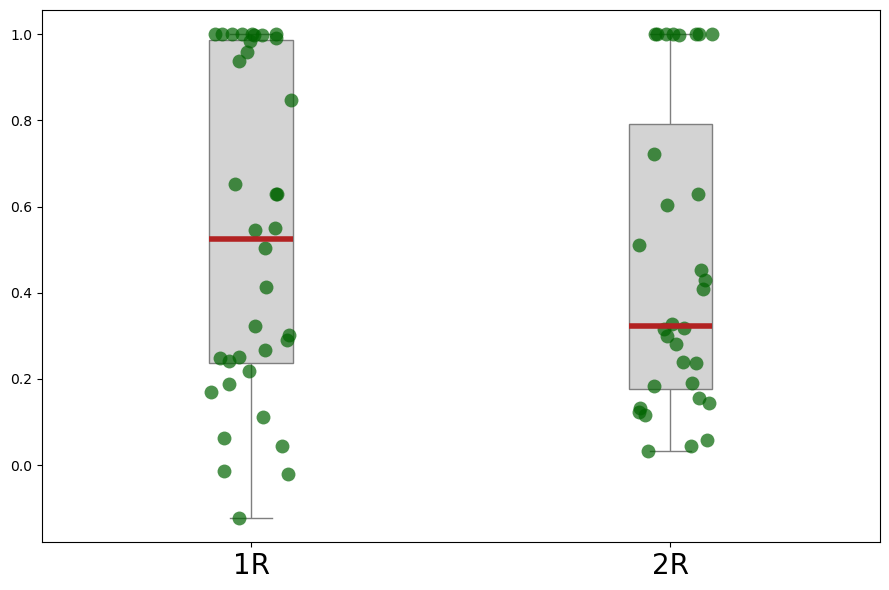

KS test for subgenome types A:
KS statistic: 0.15625, p-value: 0.739216451077269


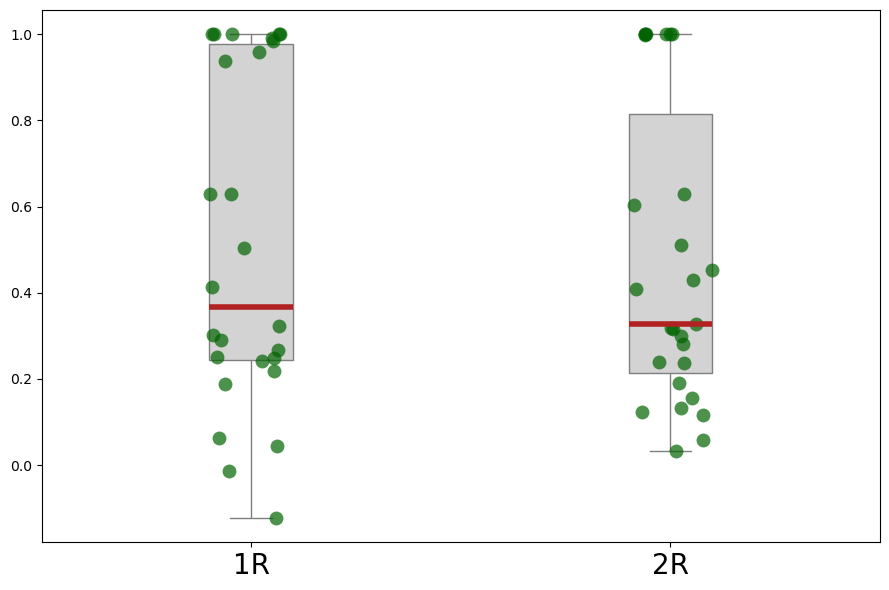

KS test for subgenome types A:
KS statistic: 0.14814814814814814, p-value: 0.8605201845267961


In [64]:
def plot_expression_correlation(df, expr_df, dic, corr_metrics):
    """
    Plots the expression correlation for each combination of subgenomes in the DataFrame.
    """
    #desired_order = ["A", "B", "C", "D"]
    desired_order = ["C+D", "A"]
    correlations = []

    for subg_type in desired_order:
        subg_df = df[df['dup_subgenome_type'] == subg_type]
        for _, row in subg_df.iterrows():
            #print(f"Processing pair ({row['miRNA_1']}, {row['miRNA_2']}) for subgenome type {subg_type}")
            expr_1 = retrieve_expression(row['miRNA_1'], expr_df, dic)
            expr_2 = retrieve_expression(row['miRNA_2'], expr_df, dic)

            corr = expression_correlation(expr_1, expr_2, corr_metrics)

            if np.isnan(corr):
                print(f"Skipping pair ({row['miRNA_1']}, {row['miRNA_2']}), missing expression data.")
                continue

            correlations.append((subg_type, corr))

    corr_df = pd.DataFrame(correlations, columns=['subgenome_pair', 'correlation'])

    if corr_df.empty:
        print("No valid correlations to plot. Check your miRNA mappings and expression DataFrame.")
        return

    plt.figure(figsize=(9, 6))
    sns.boxplot(
        x='subgenome_pair',
        y='correlation',
        data=corr_df,
        showfliers=False,
        color='lightgrey',
        width=0.2,
        linewidth=1,
        order=desired_order,
        medianprops={'color': 'firebrick', 'linewidth': 4, 'zorder': 20}
    )
    sns.stripplot(
        x='subgenome_pair',
        y='correlation',
        data=corr_df,
        color='darkgreen',
        alpha=0.7,
        s=10,
        jitter=True,
        order=desired_order
    )
    plt.xlabel('')
    plt.ylabel('')
    #plt.ylim(-0.1, 1.2)
    plt.title('')
    v = ['1R', '2R']
    plt.xticks(ticks=range(len(v)), labels=v, fontsize=20)
    plt.tight_layout()
    plt.show()
    
	# print the pvalue of ks test between the two distribution of correlation values
    if len(corr_df) > 0:
        ks_stat, ks_p_value = stats.ks_2samp(
        corr_df[corr_df['subgenome_pair'] == 'A']['correlation'],
            corr_df[corr_df['subgenome_pair'] == 'C+D']['correlation']
        )
        print(f"KS test for subgenome types {subg_type}:\nKS statistic: {ks_stat}, p-value: {ks_p_value}")
    else:
        print("No valid correlations to perform KS test.")
        
plot_expression_correlation(df_wgd_lca_parsed_subg, expr_df_norm_filtered, dic, 'pearson')
plot_expression_correlation(df_wgd_lca_parsed_subg_bifanonly, expr_df_norm_filtered, dic, 'pearson')

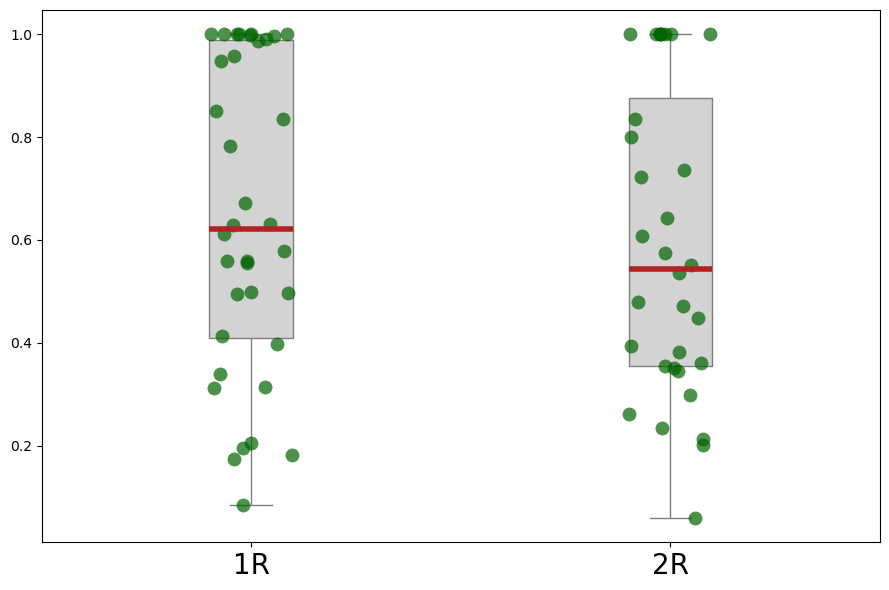

KS test for subgenome types A:
KS statistic: 0.1909722222222222, p-value: 0.4985836695445793


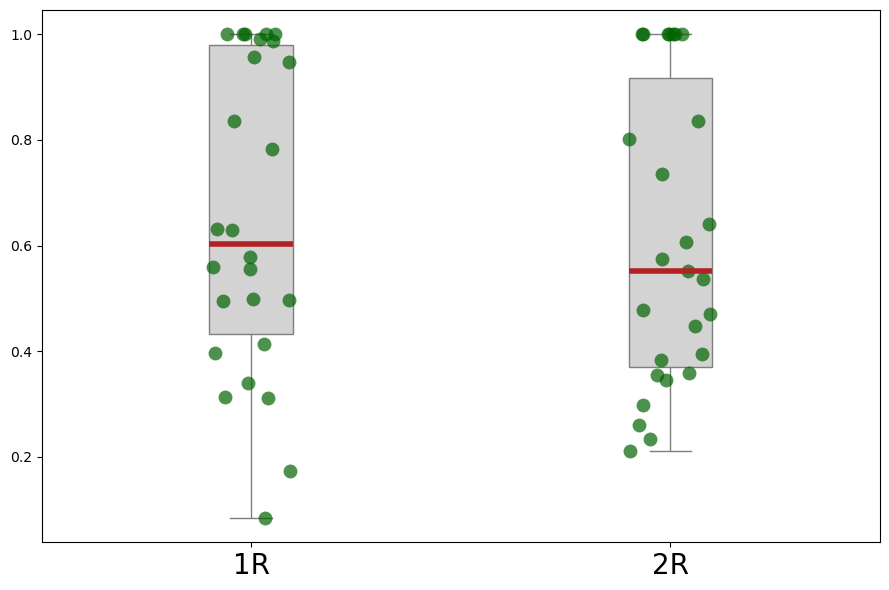

KS test for subgenome types A:
KS statistic: 0.1752136752136752, p-value: 0.7172587408546355


In [65]:
plot_expression_correlation(df_wgd_lca_parsed_subg, expr_df_norm_filtered, dic, 'cosine')
plot_expression_correlation(df_wgd_lca_parsed_subg_bifanonly, expr_df_norm_filtered, dic, 'cosine')

In [71]:
# check p-value between the same subtype before and after removing bifanonly
ks_stat_before, ks_p_value_before = stats.ks_2samp(
	df_wgd_lca_parsed_subg[df_wgd_lca_parsed_subg['dup_subgenome_type'] == 'A']['Z-score'].astype(float),
	df_wgd_lca_parsed_subg_bifanonly[df_wgd_lca_parsed_subg_bifanonly['dup_subgenome_type'] == 'A']['Z-score'].astype(float)
)
ks_stat_after, ks_p_value_after = stats.ks_2samp(
	df_wgd_lca_parsed_subg[df_wgd_lca_parsed_subg['dup_subgenome_type'] == 'C+D']['Z-score'].astype(float),
	df_wgd_lca_parsed_subg_bifanonly[df_wgd_lca_parsed_subg_bifanonly['dup_subgenome_type'] == 'C+D']['Z-score'].astype(float)
)
print(f"KS test before removing bifanonly for A: KS statistic: {ks_stat_before}, p-value: {ks_p_value_before}")
print(f"KS test after removing bifanonly for C+D: KS statistic: {ks_stat_after}, p-value: {ks_p_value_after}")

KS test before removing bifanonly for A: KS statistic: 0.15625, p-value: 0.7949069047219107
KS test after removing bifanonly for C+D: KS statistic: 0.2777777777777778, p-value: 0.15624620215021667


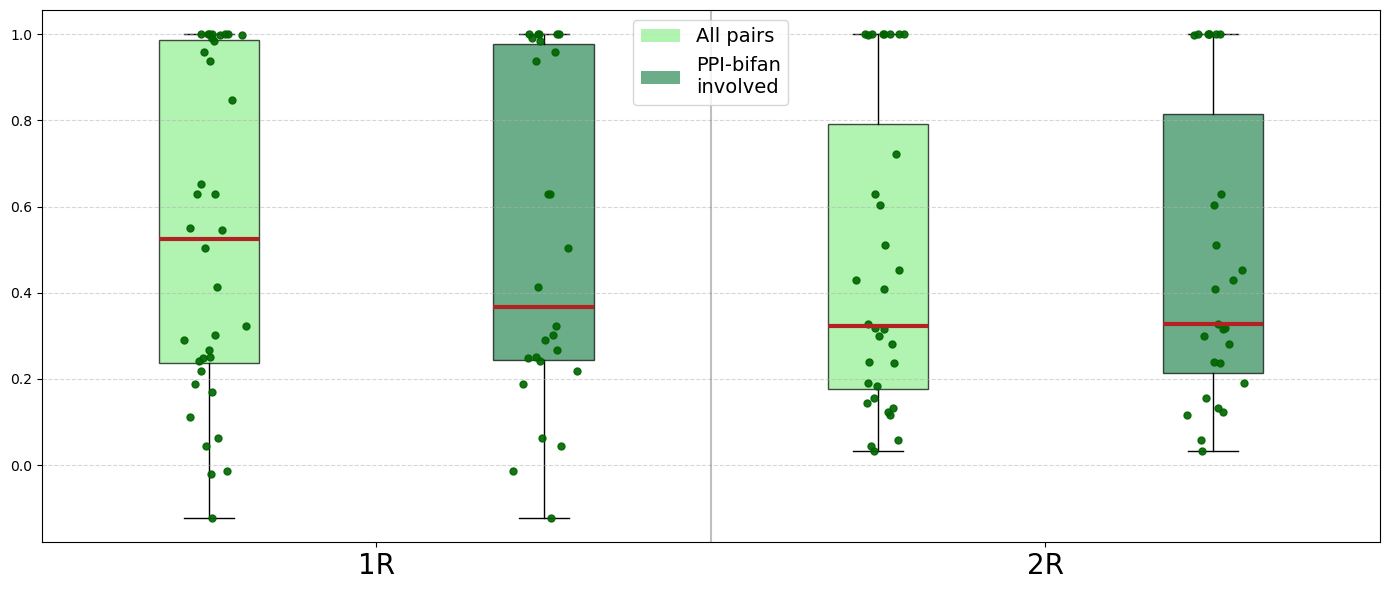

KS test for All pairs:
KS statistic: 0.1562, p-value: 0.7392
KS test for PPI-bifan
involved:
KS statistic: 0.1481, p-value: 0.8605


In [ ]:
def plot_expression_correlation_merged(df1, df2, expr_df, dic, corr_metrics, labels=None):
    """
    Plots the expression correlation for each combination of subgenomes in two DataFrames side by side.
    
    Parameters:
    - df1, df2: DataFrames with miRNA pair data
    - expr_df: Expression DataFrame
    - dic: Dictionary for miRNA mapping
    - corr_metrics: Correlation metric to use
    - labels: List of two strings for dataset labels (default: ['Dataset 1', 'Dataset 2'])
    """
    if labels is None:
        labels = ['Dataset 1', 'Dataset 2']
    
    desired_order = ["C+D", "A"]
    all_correlations = []
    
    # Process both datasets
    for dataset_idx, (df, dataset_label) in enumerate([(df1, labels[0]), (df2, labels[1])]):
        for subg_type in desired_order:
            subg_df = df[df['dup_subgenome_type'] == subg_type]
            for _, row in subg_df.iterrows():
                expr_1 = retrieve_expression(row['miRNA_1'], expr_df, dic)
                expr_2 = retrieve_expression(row['miRNA_2'], expr_df, dic)
                corr = expression_correlation(expr_1, expr_2, corr_metrics)
                if np.isnan(corr):
                    print(f"Skipping pair ({row['miRNA_1']}, {row['miRNA_2']}) for {dataset_label}, missing expression data.")
                    continue
                all_correlations.append((subg_type, corr, dataset_label))
    
    # Create combined DataFrame
    corr_df = pd.DataFrame(all_correlations, columns=['subgenome_pair', 'correlation', 'dataset'])
    
    if corr_df.empty:
        print("No valid correlations to plot. Check your miRNA mappings and expression DataFrame.")
        return
    
    # Create the plot
    plt.figure(figsize=(14, 6))
    
    # Create combined categories for x-axis positioning
    subg_types = desired_order
    datasets = labels
    
    # Set up positions for side-by-side plotting
    x_positions = []
    x_labels = []
    colors = ['lightgreen', 'seagreen']  # Different colors for different datasets

    for i, subg_type in enumerate(subg_types):
        for j, dataset in enumerate(datasets):
            x_positions.append(i * len(datasets) + j)
            x_labels.append(f"{subg_type}_{dataset}")
    
    # Plot boxplots for each combination
    box_data = []
    positions = []
    dataset_colors = []
    
    for i, subg_type in enumerate(subg_types):
        for j, dataset in enumerate(datasets):
            subset = corr_df[(corr_df['subgenome_pair'] == subg_type) & 
                           (corr_df['dataset'] == dataset)]
            if not subset.empty:
                box_data.append(subset['correlation'].values)
                positions.append(i * len(datasets) + j)
                dataset_colors.append(colors[j])
    
    # Create boxplot
    bp = plt.boxplot(box_data, positions=positions, widths=0.3, patch_artist=True,
                     showfliers=False, 
                     medianprops={'color': 'firebrick', 'linewidth': 3, 'zorder': 20},
                     # alpha
                     boxprops={'alpha': 0.3},
                     zorder=1)
    
    # Color the boxes
    for patch, color in zip(bp['boxes'], dataset_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    # Add stripplot-like scatter points
    for i, subg_type in enumerate(subg_types):
        for j, dataset in enumerate(datasets):
            subset = corr_df[(corr_df['subgenome_pair'] == subg_type) & 
                           (corr_df['dataset'] == dataset)]
            if not subset.empty:
                x_pos = i * len(datasets) + j
                y_vals = subset['correlation'].values
                # Add jitter to x positions
                x_jittered = np.random.normal(x_pos, 0.04, len(y_vals))
                plt.scatter(x_jittered, y_vals, 
                           color='darkgreen', alpha=0.9, s=25, zorder=10)
    
    # Customize the plot
    plt.xlabel('')
    plt.ylabel('')
    plt.title('')
    
    # Set x-axis labels
    main_labels = ['1R', '2R']
    main_positions = [i * len(datasets) + 0.5 for i in range(len(subg_types))]
    plt.xticks(main_positions, main_labels, fontsize=20)
    
    # Add legend
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=colors[i], alpha=0.7, 
                                   label=labels[i]) for i in range(len(labels))]
    plt.legend(handles=legend_elements, loc='upper center', fontsize=14)
    
    # Add vertical line to separate the main categories
    if len(subg_types) > 1:
        plt.axvline(x=len(datasets) - 0.5, color='gray', linestyle='-', alpha=0.5)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(f'../../local/pictures/ppi_bifan_expression_correlation_{corr_metrics}_{s}.jpg', bbox_inches='tight')
    plt.show()
    
    # Perform KS tests for each dataset
    for dataset_label in labels:
        subset = corr_df[corr_df['dataset'] == dataset_label]
        if len(subset) > 0:
            group_a = subset[subset['subgenome_pair'] == 'A']['correlation']
            group_cd = subset[subset['subgenome_pair'] == 'C+D']['correlation']
            
            if len(group_a) > 0 and len(group_cd) > 0:
                ks_stat, ks_p_value = stats.ks_2samp(group_a, group_cd)
                print(f"KS test for {dataset_label}:")
                print(f"KS statistic: {ks_stat:.4f}, p-value: {ks_p_value:.4f}")
            else:
                print(f"Insufficient data for KS test in {dataset_label}")
        else:
            print(f"No valid correlations to perform KS test for {dataset_label}")

# Usage example:
plot_expression_correlation_merged(
    df_wgd_lca_parsed_subg, 
    df_wgd_lca_parsed_subg_bifanonly, 
    expr_df_norm_filtered, 
    dic, 
    'cosine',
    labels=['All pairs', 'PPI-bifan\ninvolved']
)